<a id='top'></a>

# CSCI4022 Homework 8; Filtering and Matrix Methods
## Due Friday, April 22 at 11:59 pm to Canvas and Gradescope

#### Submit this file as a .ipynb with *all cells compiled and run* to the associated dropbox.

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.
- There are two ways to quickly make a .pdf out of this notebook for Gradescope submission.  Either:
 - Use File -> Download as PDF via LaTeX.  This will require your system path find a working install of a TeX compiler
 - Easier: Use File ->  Print Preview, and then Right-Click -> Print using your default browser and "Print to PDF"



---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) |
---
<a id='p1'></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from PIL import Image, ImageOps

***
<a id='p1'></a>
[Back to top](#top)
# Problem 1 (k-NN; 15 pts)

The [Anage](https://genomics.senescence.info/species/index.html) database is a large repositiory of biological information, and includes various properties of various animals with an eye towards understanding the effects of aging in different species.  Most of the columns should be self-explanatory, but for more information you can consult their overview, [here](https://genomics.senescence.info/help.html#anage).

A couple of [acronyms](https://genomics.senescence.info/software/demographic.html) in the columns: IMR stands for "initial mortality rate," and represents non-age related deaths.  MRDT is the "mortality doubling rate," and is a measure for the age-related species deaths.

Because it has many missing values, we will be exploring this data set as a nearest-neighbor algorith, which gives us the option to **impute** missing data as we compute similarities.

The data is loaded in with a couple of preliminary explorations below.

In [2]:
df=pd.read_csv('../data/AnAge.csv', encoding='UTF-8')
print(df.columns) #information available: many numeric columns are blank for many species
print(df.shape) #4224 species available
df.head(3)

Index(['HAGRID', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus',
       'Species', 'Common name', 'Female maturity (days)',
       'Male maturity (days)', 'Gestation/Incubation (days)', 'Weaning (days)',
       'Litter/Clutch size', 'Litters/Clutches per year',
       'Inter-litter/Interbirth interval', 'Birth weight (g)',
       'Weaning weight (g)', 'Adult weight (g)', 'Growth rate (1/days)',
       'Maximum longevity (yrs)', 'Source', 'Specimen origin', 'Sample size',
       'Data quality', 'IMR (per yr)', 'MRDT (yrs)', 'Metabolic rate (W)',
       'Body mass (g)', 'Temperature (K)', 'References'],
      dtype='object')
(4224, 31)


,HAGRID,Kingdom,Phylum,Class,Order,Family,Genus,Species,Common name,Female maturity (days),...,Source,Specimen origin,Sample size,Data quality,IMR (per yr),MRDT (yrs),Metabolic rate (W),Body mass (g),Temperature (K),References
0,3.0,Animalia,Arthropoda,Branchiopoda,Diplostraca,Daphniidae,Daphnia,pulicaria,Daphnia,NaN,...,NaN,unknown,medium,acceptable,NaN,NaN,NaN,NaN,NaN,1.294130e+11
1,5.0,Animalia,Arthropoda,Insecta,Diptera,Drosophilidae,Drosophila,melanogaster,Fruit fly,7.0,...,NaN,captivity,large,acceptable,0.05,0.04,NaN,NaN,NaN,2.203250e+37
2,6.0,Animalia,Arthropoda,Insecta,Hymenoptera,Apidae,Apis,mellifera,Honey bee,NaN,...,812,unknown,medium,acceptable,NaN,NaN,NaN,NaN,NaN,6.340740e+54


### Part A: Processing

As you can see above, the data set uses null values (`np.nan`, after loading) to denote missing information.  To set up using centered cosine similarity, you should:

- Subtract from each column the non-NaN mean for that column
- Replace any NaN values with 0's, so they don't affect cosine similarity.
- Drop any non-numeric columns or columns where the values don't correspond to physical properties of that species


### Part B: Finding a Recommendation

Zach's girlfriend thinks the `Common name` animal of `Slow loris` is the cutest creature in the world.  Use sklearn's `NearestNeighbors` to suggest to her 5 other animals that might be similar to the slow loris.  Use only the numeric data columns in the given data frame.

In [3]:
loris=df['Common name']=='Slow loris'
#here's the data:
df.loc[loris]

,HAGRID,Kingdom,Phylum,Class,Order,Family,Genus,Species,Common name,Female maturity (days),...,Source,Specimen origin,Sample size,Data quality,IMR (per yr),MRDT (yrs),Metabolic rate (W),Body mass (g),Temperature (K),References
2439,2456.0,Animalia,Chordata,Mammalia,Primates,Lorisidae,Nycticebus,coucang,Slow loris,578.0,...,671,captivity,medium,acceptable,NaN,NaN,1.504,1128.6,308.55,3.642040e+32


### Part C: Imputing Missing Data

Zach watched a cool documentary with a segment about the `Arctic fox` and watched a very young fox that had just reached weaning go on its first hunt.  He was wondering about how large that fox was, but unfortunately, the data for the `Weaning weight (g)` of the artic fox is missing!  Predict the value of this missing piece of information by:

- Finding the 10 most similar animals to the `Arctic fox` that have weaning weight data available
- Predicting the weaning weight of the arctic fox via a similarity-weighted mean of those 10 animals' weaning weights
- Remember that your data is currently **centered**, so you'll need to add the mean back in for prediction

Sanity check your answer by eyeballing the weaning weight for another fox such as the `Red fox`.

***
<a id='p2'></a>
[Back to top](#top)
# Problem 2 (SVD/PCA; 15 pts)

In this problem we'll explore the idea of using SVD as a memory saving tool.  In particular, it's sometimes used for image compression: deciding how to take a larger image and save it using less information than all of the pixels.
### Syntax: Image processing

Given is some code to load in an image of the engineering center.  Play around with it and make sure you understand the dimensions of the rbg and grayscale matrices.  Check out `plt.imshow` for documentation of the shapes of pixelated objects that can make sense to plot.  **READ** the difference between inputting a single matrix and 3-D array: you'll need to think about rescaling/normalizing if you do part C!

(575, 1500, 4)


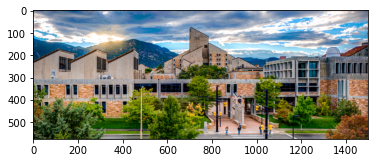

In [4]:
img = Image.open('../Data/cu_2012.png')
plt.imshow(img)

rbg=np.reshape(img.getdata(), (img.size[1],img.size[0],4)) #4 m x n arrays; R, B, G, transparancy
print(np.shape(rbg))

(575, 1500)


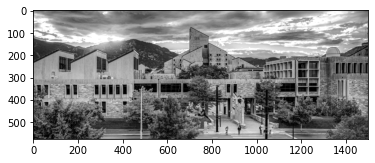

In [5]:
grayscale=np.reshape(ImageOps.grayscale(img).getdata(), (img.size[1],img.size[0]))
plt.imshow(grayscale, cmap='gray')
print(np.shape(grayscale))

### Part A: SVD
Make the singular value decomposition of the `grayscale` image matrix above.  Then use it to reduce the dimension of the problem, and approximate greyscale by only the first $k$ dimensions of the SVD.  Then:

- Plot the 3 images corresponding to $k=5, 50, 200$ in a single figure as side-by-side plots.
- For each such image, print out the exact proportion of the original number of floating point integers required to generate the image. In other words, how many elements **total** of U, $\Sigma$ and V are you using relative to the original number?

### Part B: How many should we use?
In class we discussed the heuristic of using 80-90% of the *energy* of a system to recreate the reconstruction.  How does that work for images?  Create a list of the cumulative energy retained by using the first $k=1, 2, 3, ...$ dimensions, and plot it.

Then, for the first such index where we retain 90% of the energy of the original matrix, plot that image.  Does 90% feel like a good baseline for images?  If not, state what you think seems to be appropriate for a .png of this size.

It says we should use indices 0-2, for a total of 3 columns... but that image looks terrible!  It's probably more like 98-99%, at least plotting things as small as they are on this notebook.  That's still pretty good savings!

### Part C: Extra Credit (5 pts)

Our image was in color!  Repeat the analysis in parts A/B to create a reduced dimenstional representation of **all 3** of the R, G, and B color values for each node.  Start with the `rgb` object given, and perform 3 separate SVD decompositions for the 3 colors, discarding transparancy.  At the end, create a 2x2 plot of images for using 60 singular values, including the 3 reconstructed R, G, and B matrix images and the fully colorized.

Play around with a few other values of $k$ besides 60.  Does it feel like you need more or less dimensions to be able to interpret SVDs of RBG data?  Explain.


***
<a id='p3'></a>
[Back to top](#top)
# Problem 3 (Outlier Detection; 15 pts)

The file `nba2022.csv` includes all of the major basketball statistics from the 2021-2022 NBA season.  We're going to use it to determine whether "outlierness" of players correlated with their value to the team.  Load in the file and inspect it.  A glossary for the columns is as follows below.  We're going to use this set to do some outlier detection to explore how well we can extract some of the 

For all future analysis, you should only use NBA players that played at least 1000 minutes `MIN` (around 1/4 of the seasons' possible total).

- GP Games Played
- W Wins
- L Losses
- MIN Minutes Played
- FGM Field Goals Made
- FGA Field Goals Attempted
- FG% Field Goal Percentage
- 3PM 3 Point Field Goals Made
- 3PA 3 Point Field Goals Attempted
- 3P% 3 Point Field Goals Percentage
- FTM Free Throws Made
- FTA Free Throws Attempted
- FT% Free Throw Percentage
- OREB Offensive Rebounds
- DREB Defensive Rebounds
- REB Rebounds
- AST Assists
- TOV Turnovers
- STL Steals
- BLK Blocks
- PF Personal Fouls
- FP Fantasy Points
- DD2 Double doubles
- TD3 Triple doubles
- PTS Points
- +/- Plus Minus



In [6]:
df=pd.read_csv('../Data/nba2022.csv')
df.head(8)

,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,DREB,REB,AST,TOV,STL,BLK,PF,DD2,TD3,+\-
0,Mikal Bridges,PHX,25,82,64,18,2854,1162,458,858,...,273,347,185,68,96,36,150,0,0,576
1,Miles Bridges,CHA,24,80,41,39,2837,1613,596,1214,...,469,559,300,150,74,67,193,15,0,142
2,DeMar DeRozan,CHI,32,76,43,33,2743,2118,774,1535,...,336,392,374,181,68,24,178,6,0,77
3,Jayson Tatum,BOS,24,76,49,27,2731,2046,708,1564,...,524,609,334,217,75,49,174,22,0,667
4,Saddiq Bey,DET,23,82,23,59,2704,1321,450,1136,...,334,441,233,96,73,16,128,6,0,-499
5,Tyrese Haliburton,IND,22,77,26,51,2694,1181,430,909,...,250,311,628,199,134,49,121,25,0,-327
6,Russell Westbrook,LAL,33,78,31,47,2678,1441,548,1233,...,470,580,550,295,75,20,235,28,10,-211
7,Trae Young,ATL,23,76,40,36,2652,2155,711,1544,...,234,284,737,303,72,7,128,42,0,159


### Part A: Outliers: Classical

Bi)  In the older days of NBA statistics, the most common measure of a players' value were in the triple (Points per game, Rebounds per game, Assists per game).  Create new columns in your data frame that house these 3 values.  Use `GP` for games, not the theroetical max of 82.

Bii) Use your new columns in an $n \times 3$ object and calculate the **Mahalanobis' distance** for each player.  Who are the largest 10 outliers?

Biii) Use the `decision_function` method from a fit of SKLearn's `IsolationForest` library in the import statement above.  Who are the largest 10 outliers under an Isolation Forest?


### Part B Outliers: Rate

Ci)  These days, we often get better date that measures how effective or ineffective a player is *when they're on the court*.  These are known as *rate* statistics, and require us create "per minute" statistics for each player.  Create new columns that are (Points per 36 minutes, Rebounds per 36 minutes, Assists per 36 minutes) for each player.

Cii) Use your new columns in an $n \times 3$ object and calculate the **Mahalanobis' distance** for each player.  Who are the largest 10 outliers?

Ciii) Use the `decision_function` method from a fit of SKLearn's `IsolationForest` library in the import statement above.  Who are the largest 10 outliers under an Isolation Forest?


### Part C: Outliers: Which is better?
For whether or not our methods are extracting players that are of value to the team, consider some other measures.

The League votes on the single "Most Valuable Player" in the coming days.  The nominal favorites are Nikola Jokic, Joel Embiid, and Giannis Antetokounmpo.  How do they appear on your lists?

Consider the top 20 by "win shares", an "advanced" stat listed [here](https://www.basketball-reference.com/leagues/NBA_2022_advanced.html#advanced_stats::ws).

Modern NBA thinking suggests that rate statistics are more useful than simple aggregates.  Do we seem to get a better top-10 list from rate statistics?  Are any of your outliers coming being outliers in possibly **not** valuable ways?
